In [0]:
import json

def read_json(filename): 
  f = open (filename, "r") 
    
  # Reading from file 
  data = json.loads(f.read()) 
  return data

data = read_json("data.json")  

In [2]:
print(data)

{'train': [{'input': [[0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0], [0, 0, 9, 0, 0, 9, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0], [0, 9, 9, 9, 0, 9, 0, 0, 0, 0, 0, 9, 0, 9, 9, 9, 0], [0, 0, 9, 0, 0, 9, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0], [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9], [0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 9, 0, 0, 9, 0, 0, 9, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 9, 0, 9, 0, 9, 0, 9, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 9, 0, 0, 9, 0, 0, 9, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0], [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9], [0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0], [0, 0, 9, 0, 0, 9, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0], [0, 9, 9, 9, 0, 9, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0], [0, 0, 9, 0, 0, 9, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0]], 'output': [[0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0], [0, 0, 9, 0,

In [3]:
print(len(data['train']))
print(len(data['test']))

3
1


In [0]:

import numpy as np

train_input = np.zeros(shape=[3,17,17,1])
train_output = np.zeros(shape=[3,17,17,1])

test_input = np.zeros(shape=[1,17,17,1])
test_output = np.zeros(shape=[1,17,17,1])

for i in range(3):
  v = data['train'][i]
  inp = v['input']
  out = v['output']
  train_input[i,:,:,0] = inp
  train_output[i,:,:,0] = out

for i in range(1):
  v = data['test'][i]
  inp = v['input']
  out = v['output']
  test_input[i,:,:,0] = inp
  test_output[i,:,:,0] = out

In [5]:
print(test_input.shape)

(1, 17, 17, 1)


In [6]:
print(train_input.shape)

(3, 17, 17, 1)


In [0]:
train_input/=9.0
train_output/=9.0
test_input/=9.0
test_output/=9.0

# train_input-=0.5
# train_output-=0.5
# test_input-=0.5
# test_output-=0.5

# train_input*=2.0
# train_output*=2.0
# test_input*=2.0
# test_output*=2.0


In [0]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
from torch.utils import data
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F

In [0]:
tensor_train_input = torch.Tensor(train_input)
tensor_train_output = torch.Tensor(train_output)

tensor_test_input = torch.Tensor(test_input)
tensor_test_output = torch.Tensor(test_output)

tensor_train_input = tensor_train_input.permute(0,3,1,2)
tensor_train_output = tensor_train_output.permute(0,3,1,2)
tensor_test_input = tensor_test_input.permute(0,3,1,2)
tensor_test_output = tensor_test_output.permute(0,3,1,2)

In [0]:
from torch.utils import data
trainset = data.TensorDataset(tensor_train_input,tensor_train_output)
valset = data.TensorDataset(tensor_test_input,tensor_test_output)
batch_size = 3
num_workers = 1
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=num_workers)


In [0]:
import math

import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F


def hard_sigmoid(x):
    return torch.min(torch.max(x, torch.zeros_like(x)), torch.ones_like(x))


class _L0Norm(nn.Module):

    def __init__(self, origin, loc_mean=0, loc_sdev=0.01, beta=2 / 3, gamma=-0.1,
                 zeta=1.1, fix_temp=True):
        """
        Base class of layers using L0 Norm
        :param origin: original layer such as nn.Linear(..), nn.Conv2d(..)
        :param loc_mean: mean of the normal distribution which generates initial location parameters
        :param loc_sdev: standard deviation of the normal distribution which generates initial location parameters
        :param beta: initial temperature parameter
        :param gamma: lower bound of "stretched" s
        :param zeta: upper bound of "stretched" s
        :param fix_temp: True if temperature is fixed
        """
        super(_L0Norm, self).__init__()
        self._origin = origin
        self._size = self._origin.weight.size()
        self.loc = nn.Parameter(torch.zeros(self._size).normal_(loc_mean, loc_sdev))
        self.temp = beta if fix_temp else nn.Parameter(torch.zeros(1).fill_(beta))
        self.register_buffer("uniform", torch.zeros(self._size))
        self.gamma = gamma
        self.zeta = zeta
        self.gamma_zeta_ratio = math.log(-gamma / zeta)

    def _get_mask(self):
        if self.training:
            self.uniform.uniform_()
            u = Variable(self.uniform)
            s = F.sigmoid((torch.log(u) - torch.log(1 - u) + self.loc) / self.temp)
            s = s * (self.zeta - self.gamma) + self.gamma
            penalty = F.sigmoid(self.loc - self.temp * self.gamma_zeta_ratio).sum()
        else:
            s = F.sigmoid(self.loc) * (self.zeta - self.gamma) + self.gamma
            penalty = 0
        return hard_sigmoid(s), penalty


class L0Linear(_L0Norm):
    def __init__(self, in_features, out_features, bias=True, **kwargs):
        super(L0Linear, self).__init__(nn.Linear(in_features, out_features, bias=bias), **kwargs)

    def forward(self, input):
        mask, penalty = self._get_mask()
        return F.linear(input, self._origin.weight * mask, self._origin.bias), penalty


class L0Conv2d(_L0Norm):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True,
                 **kwargs):
        super(L0Conv2d, self).__init__(nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding,
                                                 dilation=dilation, groups=groups, bias=bias), **kwargs)

    def forward(self, input):
        mask, penalty = self._get_mask()
        conv = F.conv2d(input, self._origin.weight * mask, self._origin.bias, stride=self._origin.stride,
                        padding=self._origin.padding, dilation=self._origin.dilation, groups=self._origin.groups)
        return conv, penalty


class L0Sequential(nn.Sequential):
    def forward(self, input):
        penalty = 0
        for module in self._modules.values():
            output = module(input)
            if isinstance(output, tuple):
                input = output[0]
                penalty += output[1]
            else:
                input = output
        return input, penalty

In [0]:
class Replication(nn.Module):
  def __init__(self):
    super(Replication, self).__init__()
    # x = torch.tensor([[1., -1.], [1., 1.]], requires_grad=True)
    # self.w = torch.empty(289, 25)
    # nn.init.sparse_(self.w, sparsity=1/289)
    # self.b = torch.empty(25)
    # nn.init.zeros_(self.b)
    # self.conv0 = nn.Conv2d(1, 1, 5, stride=6, padding=0)
    self.conv1 = nn.Conv2d(1, 2, 5, stride=6, padding=0)
    self.conv2 = nn.ConvTranspose2d(2, 4, 5, stride=6, padding=0)
    self.conv11 = nn.Conv2d(1, 1, 5, stride=1, padding=2)
    self.conv12 = nn.Conv2d(1, 1, 5, stride=1, padding=2)
    self.conv13 = nn.Conv2d(1, 1, 5, stride=1, padding=2)
    self.conv14 = nn.Conv2d(1, 1, 5, stride=1, padding=2)
    # self.conv3 = nn.Conv2d(1, 1, 5, stride=1, padding=2)
    # self.conv4 = nn.Conv2d(1, 1, 5, stride=1, padding=2)
    # self.conv5 = nn.ConvTranspose2d(1, 1, 5, stride=1, padding=2)
    # self.conv6 = nn.ConvTranspose2d(1, 1, 5, stride=1, padding=2)
    # self.conv7 = nn.ConvTranspose2d(1, 1, 5, stride=1, padding=2)
    # self.conv8 = nn.ConvTranspose2d(1, 1, 5, stride=1, padding=2)
    # self.conv1 = nn.ConvTranspose2d(1, 1, 5, stride=1, padding=2)
    # self.fc1 = nn.Linear(17*17, 3*3)
    # self.fc2 = nn.Linear(3*3, 17*17)

    self.dropout = nn.Dropout(0.1)
    # self.fc1 = nn.Linear(3*6, 3*3)
    # self.fc1 = nn.Linear(17*17, 17*17)
    # self.fc2 = nn.Linear(17*17, 17*17)
    # self.fc3 = nn.Linear(17*17, 5*5)
    # self.fc4 = nn.Linear(5*5, 17*17)
    self.fc4 = L0Linear(5*5, 17*17)
    # self.fc4 = L0Linear(17*17, 17*17)
    # self.fc1.weight.data.uniform_(0.0, 1.0)
    # self.fc1.weight.data = torch.round(self.fc1.weight.data)
    # self.fc1.bias.data.fill_(0)
    # self.fc1.weight.data.normal_(0.0,1/289)
    # self.fc1.weight.data.type(torch.int)
    # self.fc1.bias.data.type(torch.int)
    # fc1.weight.data.fill_(0.01)
    
    # self.conv1 = nn.Conv2d(1, 1, 5, stride=1, padding=2)
    # self.conv2 = nn.Conv2d(1, 1, 3, stride=1, padding=1)
    # self.conv3 = nn.Conv2d(1, 1, 3, stride=1, padding=1)
    # self.conv4 = nn.Conv2d(1, 1, 3, stride=1, padding=1)
    

  def forward(self, x):
    # x = x.view(x.size(0), -1)
    # x = F.sigmoid(torch.matmul(x, self.w) + self.b)
    # x = F.sigmoid(self.fc4(x))
    # x = self.dropout(F.sigmoid(self.fc1(x)))
    # x = self.dropout(F.sigmoid(self.fc2(x)))
    # x = F.sigmoid(self.fc3(x))
    # x = F.sigmoid(self.fc4(x))
    # x = x.view(x.size(0), 1, 17, 17)
    # x0 = self.conv0(x)
    # print(x.size())

    # x1 = self.dropout(F.relu(self.conv11(x)))
    # x1 = self.dropout(F.relu(self.conv12(x1)))
    # x1 = self.dropout(F.relu(self.conv13(x1)))
    # x1 = self.dropout(F.relu(self.conv14(x1)))

    # x = x.view(x.size(0), -1)
    # x2 = self.dropout(F.relu(self.fc1(x)))
    # x2 = x2.view(x2.size(0), 1, 17, 17)
    # x = x.view(x.size(0), 1, 17, 17)

    # x = self.dropout(F.relu(self.conv1(x)))
    # print(x.size())
    # x = x.view(x.size(0), -1)
    # x = F.relu(self.fc1(x))   
    # x = x.view(x.size(0), 1, 3, 3) 
    # print(x.size())
    # x = self.dropout(F.relu(self.conv2(x)))
    # x = torch.sum(x, axis=1)
    # x = x.view(x.size(0), 1, x.size(1), x.size(2))
    # x = x+x1+x2
    x = torch.tensor(x[:,:,:5,:5])
    # print(x.size())
    # print(x.shape)
    # x = x.view(x.size(0), -1)
    x = x.view(x.size(0), -1)
    # x = F.relu(self.fc4(x))
    x = self.fc4(x)[0]
    x = F.relu(x)
    # print(x)
    # print(x[0].size())
    x = x.view(x.size(0), 1, 17, 17)
    # x = F.relu(self.conv11(x))
    # x = F.relu(self.conv12(x))
    # print(x.size())

    # return 0
    # print(x.size())
    # print()
    # x = self.dropout(F.relu(self.conv3(x)))
    # x = self.dropout(F.relu(self.conv4(x)))
    # x = self.dropout(F.relu(self.conv5(x)))
    # x = F.relu(self.conv5(x))
    # x = F.relu(self.conv6(x))
    # x = F.relu(self.conv7(x))
    # x = F.relu(self.conv8(x))
    # # x2 = F.relu(self.conv2(x1))
    # x3 = F.relu(self.conv3(x2))
    # x4 = F.relu(sel/f.conv4(x3))
    # x5 = F.relu(self.conv5(x4))
    # x6 = F.relu(self.conv6(x5))
    # x7 = F.relu(self.conv7(x6))
    # x8 = F.relu(self.conv8(x7))
    return x

In [0]:
model = Replication()

In [0]:
# criterion = nn.CrossEntropyLoss()
# criterion = nn.BCELoss()
# criterion = nn.BCEWithLogitsLoss()
criterion = nn.MSELoss()
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [0]:
def get_accuracy(inputs, gt, predictions):
  # print(predictions.size())
  # print(gt.size())
  # return 10, 10  
  inputs = inputs.detach().numpy()
  predictions = predictions.detach().numpy()
  gt = gt.detach().numpy()
  total = 0
  correct = 0

  for b in range(inputs.shape[0]):
    inputs_i = np.reshape(inputs[b], newshape=[inputs.shape[2], inputs.shape[3]])
    predictions_i = np.reshape(predictions[b], newshape=[predictions.shape[2], predictions.shape[3]])
    gt_i = np.reshape(gt[b], newshape=[gt.shape[2], gt.shape[3]])
    # plt.imshow(inputs_i)
    # plt.show()
    # plt.imshow(gt_i)
    # plt.show()
    # plt.imshow(predictions_i)
    # plt.show()
    for i in range(gt_i.shape[0]):
      for j in range(gt_i.shape[1]):
        # print(inputs_i[i,j]," .. ",gt_i[i,j]," ",predictions_i[i,j])
        # if inputs_i[i,j] != gt_i[i,j]:
        total += 1
        if gt_i[i,j] == predictions_i[i,j]:
          # print(gt_i[i,j]," ",predictions_i[i,j])
          correct += 1
        # print(correct," ",total)
      # break
    # plt.imshow(gt_i)
    # plt.show()
    # plt.imshow(predictions_i)
    # plt.show()
  return correct, total
  # predictions = torch.max(predictions, axis=1)[1]
  # ab = torch.abs(predictions-labels)
  # ab = ab.detach().numpy()
  # mn = np.minimum(ab, 1)
  # eq = 1-mn
  # correct = np.sum(eq)
  # total = eq.shape[0]
  # return correct, total

In [0]:
print_every = 500
epochs = 10000

In [0]:
highest_val = 0.0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


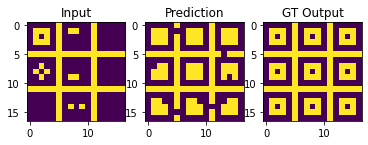

843   867
271   289
0.9377162629757786
Epoch:  1  Loss:  0.018279539421200752  Train-Accuracy:  0.972318339100346  Val Loss:  0.040689509361982346  Val-Accuracy:  0.9377162629757786


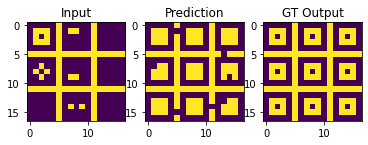

845   867
273   289
0.9446366782006921
Epoch:  501  Loss:  0.01628142222762108  Train-Accuracy:  0.9746251441753172  Val Loss:  0.039200350642204285  Val-Accuracy:  0.9446366782006921


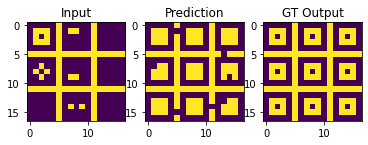

846   867
273   289
0.9446366782006921
Epoch:  1001  Loss:  0.016349023208022118  Train-Accuracy:  0.9757785467128027  Val Loss:  0.038210585713386536  Val-Accuracy:  0.9446366782006921


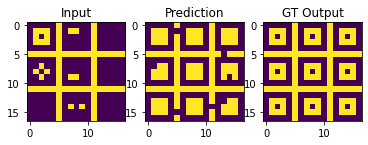

846   867
273   289
0.9446366782006921
Epoch:  1501  Loss:  0.017725827172398567  Train-Accuracy:  0.9757785467128027  Val Loss:  0.03719634562730789  Val-Accuracy:  0.9446366782006921


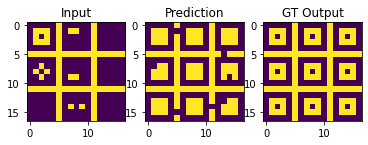

846   867
273   289
0.9446366782006921
Epoch:  2001  Loss:  0.015937956050038338  Train-Accuracy:  0.9757785467128027  Val Loss:  0.03646213188767433  Val-Accuracy:  0.9446366782006921


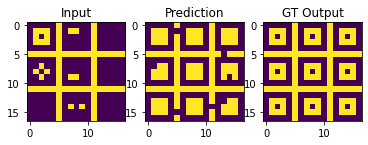

839   867
273   289
0.9446366782006921
Epoch:  2501  Loss:  0.017999963834881783  Train-Accuracy:  0.9677047289504037  Val Loss:  0.03594113141298294  Val-Accuracy:  0.9446366782006921


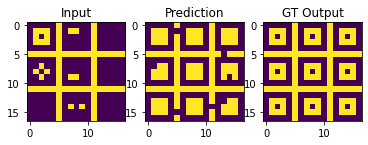

845   867
273   289
0.9446366782006921
Epoch:  3001  Loss:  0.015826314687728882  Train-Accuracy:  0.9746251441753172  Val Loss:  0.03531092777848244  Val-Accuracy:  0.9446366782006921


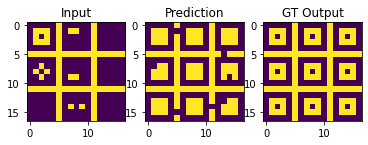

847   867
273   289
0.9446366782006921
Epoch:  3501  Loss:  0.01585441827774048  Train-Accuracy:  0.9769319492502884  Val Loss:  0.03465230017900467  Val-Accuracy:  0.9446366782006921


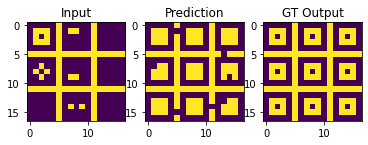

847   867
273   289
0.9446366782006921
Epoch:  4001  Loss:  0.01585364155471325  Train-Accuracy:  0.9769319492502884  Val Loss:  0.03431806340813637  Val-Accuracy:  0.9446366782006921


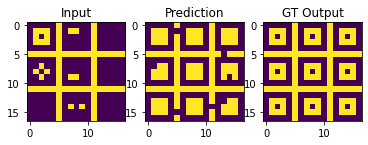

847   867
273   289
0.9446366782006921
Epoch:  4501  Loss:  0.015283135697245598  Train-Accuracy:  0.9769319492502884  Val Loss:  0.033704210072755814  Val-Accuracy:  0.9446366782006921


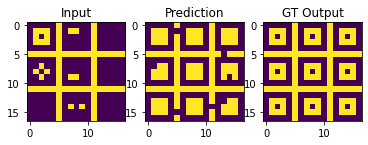

846   867
273   289
0.9446366782006921
Epoch:  5001  Loss:  0.015564501285552979  Train-Accuracy:  0.9757785467128027  Val Loss:  0.03315308690071106  Val-Accuracy:  0.9446366782006921


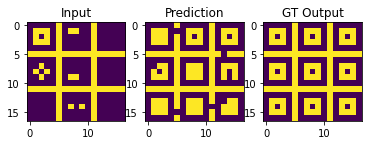

845   867
277   289
0.9584775086505191
Epoch:  5501  Loss:  0.015737228095531464  Train-Accuracy:  0.9746251441753172  Val Loss:  0.03288561478257179  Val-Accuracy:  0.9584775086505191


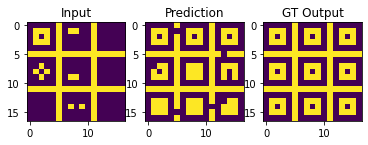

846   867
278   289
0.9619377162629758
Epoch:  6001  Loss:  0.015940675511956215  Train-Accuracy:  0.9757785467128027  Val Loss:  0.03250667452812195  Val-Accuracy:  0.9619377162629758


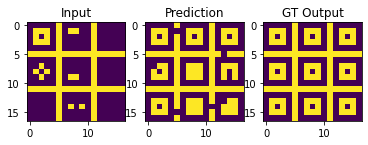

846   867
279   289
0.9688581314878892
Epoch:  6501  Loss:  0.014473281800746918  Train-Accuracy:  0.9757785467128027  Val Loss:  0.03228095546364784  Val-Accuracy:  0.9653979238754326


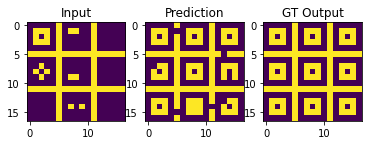

845   867
281   289
0.972318339100346
Epoch:  7001  Loss:  0.014725867658853531  Train-Accuracy:  0.9746251441753172  Val Loss:  0.03199306130409241  Val-Accuracy:  0.972318339100346


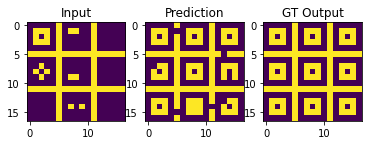

849   867
281   289
0.972318339100346
Epoch:  7501  Loss:  0.014262683689594269  Train-Accuracy:  0.9792387543252595  Val Loss:  0.03167152777314186  Val-Accuracy:  0.972318339100346


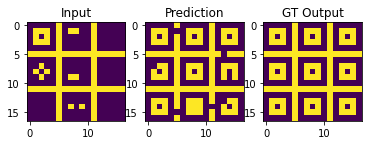

844   867
281   289
0.972318339100346
Epoch:  8001  Loss:  0.014671273529529572  Train-Accuracy:  0.9734717416378316  Val Loss:  0.03147050738334656  Val-Accuracy:  0.972318339100346


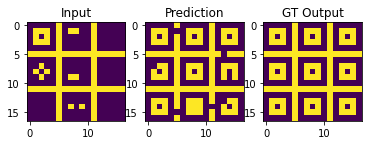

842   867
281   289
0.972318339100346
Epoch:  8501  Loss:  0.015481526032090187  Train-Accuracy:  0.9711649365628604  Val Loss:  0.031095148995518684  Val-Accuracy:  0.972318339100346


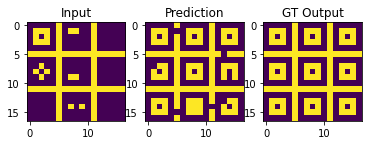

847   867
281   289
0.972318339100346
Epoch:  9001  Loss:  0.013772532343864441  Train-Accuracy:  0.9769319492502884  Val Loss:  0.030969487503170967  Val-Accuracy:  0.972318339100346


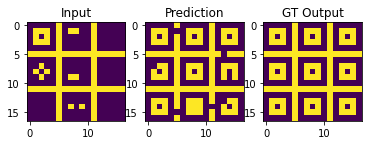

844   867
281   289
0.972318339100346
Epoch:  9501  Loss:  0.014627602882683277  Train-Accuracy:  0.9734717416378316  Val Loss:  0.03080797754228115  Val-Accuracy:  0.972318339100346
Finished Training


In [91]:
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    correct = 0
    total = 0
    total_loss = 0.0
    model.train()
    num_batches = 1

    for i, data in enumerate(trainloader, 0):
        optimizer.zero_grad()

        inputs, outputs = data
        preds = model(inputs)
        # print(preds)
        # preds = torch.round(preds)
        # print(preds)
        # print(inputs)
        # print(outputs)
        # break
        
        batch_correct, batch_total = get_accuracy(inputs, outputs, torch.round(preds))
        correct += batch_correct
        total += batch_total
        loss = criterion(outputs.view(outputs.size(0), -1), preds.view(preds.size(0), -1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        total_loss += running_loss
        num_batches += 1
        running_loss = 0.0
    # break
    val_correct = 0
    val_total = 0
    val_batches = 0
    val_total_loss = 0.0
    model.eval()
    with torch.no_grad():
      for i, data in enumerate(valloader, 0):
        inputs, outputs = data
        preds = model(inputs)
        if epoch%print_every == 0:
          preview(inputs, outputs, torch.round(preds))
        # preds = torch.round(preds)
        # if epoch%print_every == 0:
          # preview(inputs, outputs, preds)
        batch_correct, batch_total = get_accuracy(inputs, outputs, torch.round(preds))
        # batch_correct, batch_total = get_accuracy(inputs, outputs, preds)
        val_correct += batch_correct
        val_total += batch_total
        val_batches += 1
        val_loss = criterion(outputs.view(outputs.size(0), -1), preds.view(preds.size(0), -1))
        val_total_loss += val_loss.detach().numpy()
        
    if val_correct/val_total > highest_val:
      highest_val = val_correct/val_total
    if epoch % print_every == 0:
      print(correct," ",total)
      print(val_correct," ",val_total)
      print(highest_val)
      print("Epoch: ",epoch+1," Loss: ",total_loss/num_batches," Train-Accuracy: ", correct/total," Val Loss: ",val_total_loss/val_batches," Val-Accuracy: ",val_correct/val_total)
      
    

print('Finished Training')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


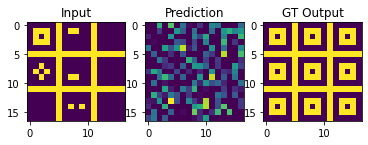

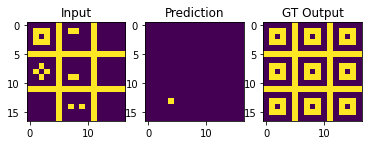

In [47]:
import matplotlib.pyplot as plt
def post_process(data):
  data = data.detach().numpy()
  data = np.reshape(data, newshape=[data.shape[2], data.shape[3]])
  return data

def preview(inputs, outputs, preds):
    inputs = post_process(inputs)
    preds = post_process(preds)
    outputs = post_process(outputs)
    plt.subplot(1,3,1)
    plt.imshow(inputs)
    plt.title("Input")
    plt.subplot(1,3,2)
    plt.imshow(preds)
    plt.title("Prediction")
    plt.subplot(1,3,3)
    plt.imshow(outputs)
    plt.title("GT Output")
    plt.show()


model.eval()
with torch.no_grad():
  for i, data in enumerate(valloader, 0):
    inputs, outputs = data
    preds = model(inputs)
    preview(inputs, outputs, preds)
    preview(inputs, outputs, torch.round(preds))

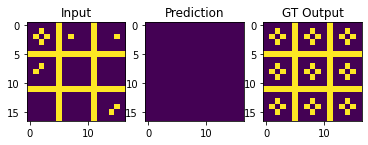

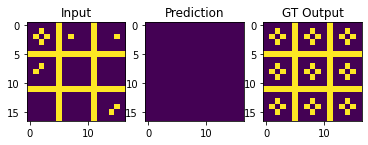

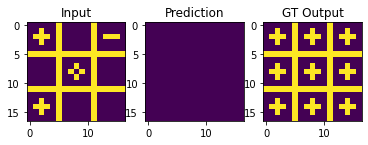

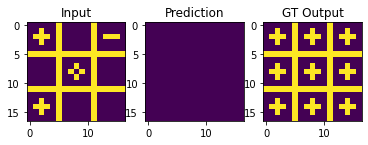

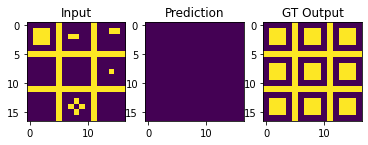

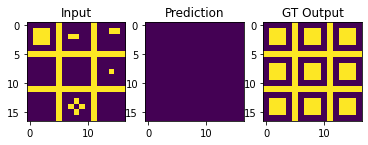

In [18]:
import matplotlib.pyplot as plt
def post_process(data):
  data = data.detach().numpy()
  data = np.reshape(data, newshape=[data.shape[2], data.shape[3]])
  return data

def preview(inputs, outputs, preds):
    inputs = post_process(inputs)
    preds = post_process(preds)
    outputs = post_process(outputs)
    plt.subplot(1,3,1)
    plt.imshow(inputs)
    plt.title("Input")
    plt.subplot(1,3,2)
    plt.imshow(preds)
    plt.title("Prediction")
    plt.subplot(1,3,3)
    plt.imshow(outputs)
    plt.title("GT Output")
    plt.show()


model.eval()
with torch.no_grad():
  for i, data in enumerate(trainloader, 0):
    inputs, outputs = data
    preds = model(inputs)
    for i in range(inputs.size(0)):
      preview(inputs[i:i+1], outputs[i:i+1], preds[i:i+1])
      preview(inputs[i:i+1], outputs[i:i+1], torch.round(preds[i:i+1]))